# Visualizing What Convolutional Neural Networks Learn: Feature Maps & Filters

**Author:** Praneeth Kumar Chapalabandla

**GitHub:** https://github.com/praneeth04-ai429/neural_network_

This notebook demonstrates how Convolutional Neural Networks (CNNs) learn hierarchical visual features.  
We use a small CNN trained on Fashion-MNIST and visualize:
- Learned convolutional filters  
- Intermediate feature maps  
- How representations evolve from input to deeper layers  

All figures generated here will be used in the accompanying tutorial webpage.

In [12]:
# Imports and environment setup
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.set_num_threads(2)
os.makedirs("figs", exist_ok=True)

In [13]:
# Configuration and reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device("cpu")
BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-3

DEVICE, BATCH_SIZE, EPOCHS

(device(type='cpu'), 64, 5)

In [3]:
# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(test_ds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:08<00:00, 3.01MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 96.1kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:03<00:00, 1.26MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 2.83MB/s]


(60000, 10000)

In [4]:
# Define a small CNN for feature visualization
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(2,2)
        self.fc    = nn.Linear(16*14*14, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # Feature Map 1
        x = self.relu(self.conv2(x))      # Feature Map 2
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SmallCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [5]:
# Training loop
history = {"loss": [], "acc": []}

for epoch in range(EPOCHS):
    model.train()
    total, correct, running_loss = 0, 0, 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        pred = out.argmax(1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    history["loss"].append(epoch_loss)
    history["acc"].append(epoch_acc)

epoch_loss, epoch_acc

(0.2264372073809306, 0.9182666666666667)

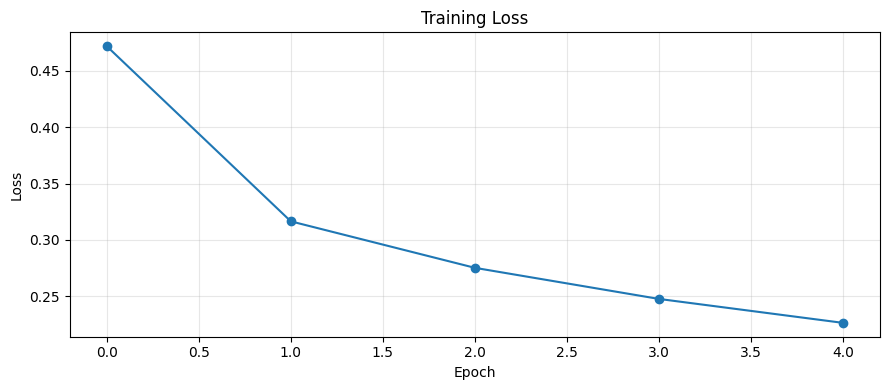

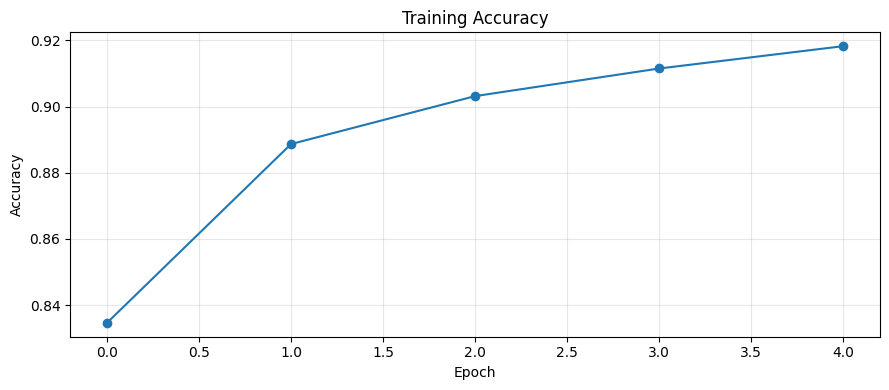

In [6]:
# Plot training loss and accuracy
plt.figure(figsize=(9,4))
plt.plot(history["loss"], marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/training_loss.png", dpi=150)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(history["acc"], marker='o')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/training_accuracy.png", dpi=150)
plt.show()

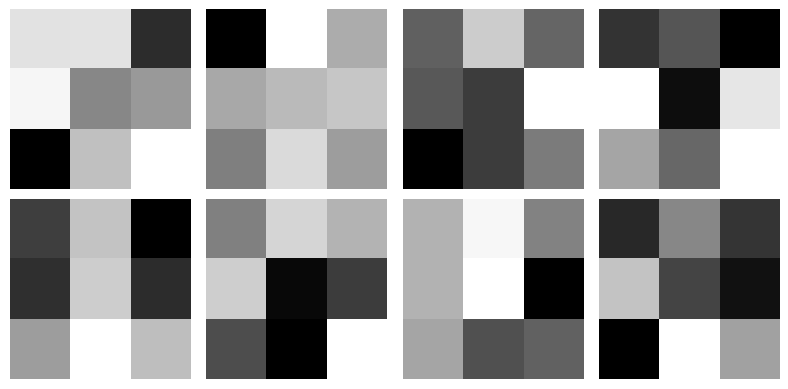

In [7]:
# Visualize learned filters from conv1
filters = model.conv1.weight.data.clone()

fig, axes = plt.subplots(2, 4, figsize=(8,4))
for i, ax in enumerate(axes.flat):
    f = filters[i,0,:,:]
    f = (f - f.min()) / (f.max() - f.min())
    ax.imshow(f, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.savefig("figs/filters_conv1.png", dpi=150)
plt.show()

In [8]:
# Extract intermediate feature maps for a single test image
model.eval()
xb, yb = next(iter(test_loader))
xb = xb[:1].to(DEVICE)

with torch.no_grad():
    fm1 = model.relu(model.conv1(xb))
    fm2 = model.relu(model.conv2(fm1))

fm1.shape, fm2.shape

(torch.Size([1, 8, 28, 28]), torch.Size([1, 16, 28, 28]))

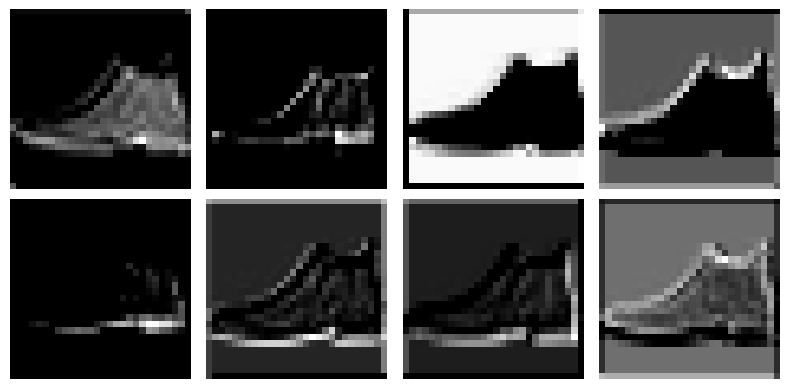

In [9]:
# Visualize first-layer feature maps
maps = fm1.squeeze(0)

fig, axes = plt.subplots(2, 4, figsize=(8,4))
for i, ax in enumerate(axes.flat):
    m = maps[i]
    m = (m - m.min()) / (m.max() - m.min())
    ax.imshow(m.cpu(), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.savefig("figs/featuremaps_conv1.png", dpi=150)
plt.show()

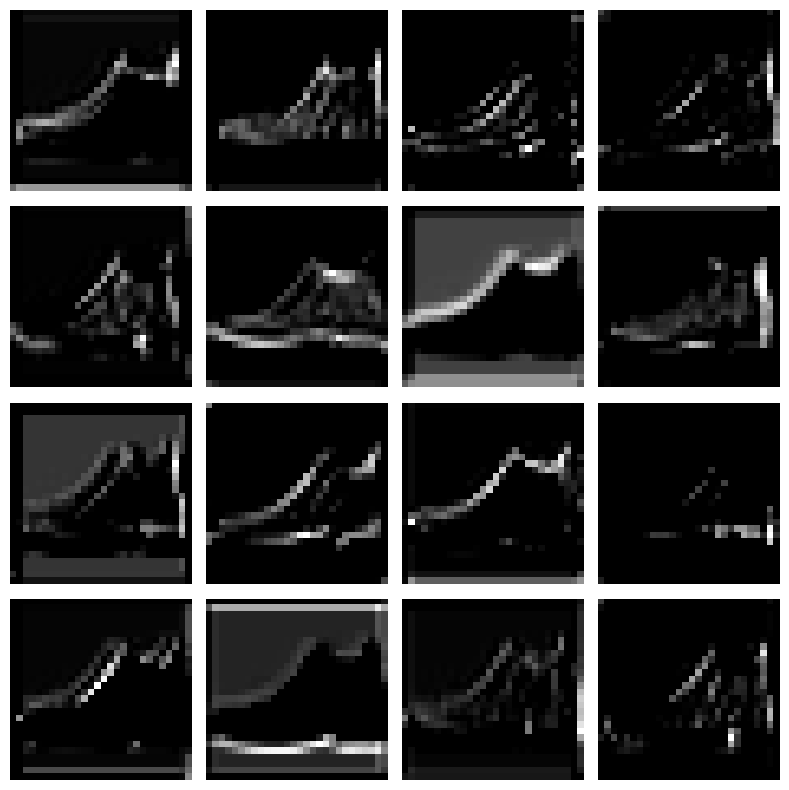

In [10]:
# Visualize second-layer feature maps
maps = fm2.squeeze(0)

fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    m = maps[i]
    m = (m - m.min()) / (m.max() - m.min())
    ax.imshow(m.cpu(), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.savefig("figs/featuremaps_conv2.png", dpi=150)
plt.show()

In [11]:
# Save a summary with final accuracy
with open("figs/summary.txt", "w") as f:
    f.write("Final training accuracy: %.4f\n" % history["acc"][-1])

history["acc"][-1]

0.9182666666666667

# References

- LeCun, Y. et al. "Gradient-Based Learning Applied to Document Recognition." Proceedings of the IEEE, 1998.  
- Goodfellow, I., Bengio, Y., Courville, A. *Deep Learning*. MIT Press, 2016.  
- Dumoulin, V., Visin, F. "A guide to convolution arithmetic for deep learning." arXiv:1603.07285  
- PyTorch Documentation: https://pytorch.org/docs/stable/  
- Fashion-MNIST Dataset: https://github.com/zalandoresearch/fashion-mnist